# HOMEWORK

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from Kaggle or download using wget link mentioned below:

wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [1]:
import jupyter_black
jupyter_black.load()

In [2]:
!wget "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"

--2022-10-16 00:01:20--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1.36M  --.-KB/s    in 0.1s    

2022-10-16 00:01:20 (9.32 MB/s) - ‘housing.csv.1’ saved [1423529/1423529]



In [3]:
# @ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [4]:
PATH = "./housing.csv"
select_cols = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "median_house_value",
    "ocean_proximity",
]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

* Apply the log transform to median_house_value.
* Do train/validation/test split with 60%/20%/20% distribution.
* Use the train_test_split function and set the random_state parameter to 1.

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

* We will use DictVectorizer to turn train and validation into matrices.

In [6]:
features = select_cols.copy()
features.remove("median_house_value")

In [7]:
train_dicts = df_train[features].to_dict(orient="records")
val_dicts = df_val[features].to_dict(orient="records")

---

## Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1

In [8]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [9]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

Which feature is used for splitting the data?

* **`ocean_proximity=INLAND`**
* `total_rooms`
* `latitude`
* `population`

In [10]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/Users/davidcolton/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


---

## Question 2

Train a random forest model with these parameters:

* n_estimators=10
* random_state=1
* n_jobs=-1 (optional-to make training faster)

In [11]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [12]:
y_pred = rf.predict(X_val)
round(mean_squared_error(y_val, y_pred, squared=False), 3)

0.246

What's the RMSE of this model on validation?

* 0.05
* **0.25**
* 0.55
* 0.85

---

## Question 3

Now, let's experiment with the n_estimators parameter.

* Try different values of this parameter from 10 to 200 with step 10.
* Set random_state to 1.
* Evaluate the model on the validation dataset.

In [13]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = mean_squared_error(y_val, y_pred, squared=False)

    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=["n_estimators", "rmse"])

  0%|          | 0/20 [00:00<?, ?it/s]

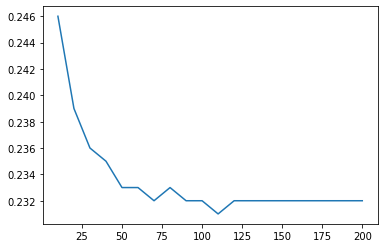

In [14]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

In [38]:
# It appears to have a minimum RMSE between 60 & 80
# Let's zoom in
scores = []

for n in tqdm(range(60, 80)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = mean_squared_error(y_val, y_pred, squared=False)

    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=["n_estimators", "rmse"])

  0%|          | 0/20 [00:00<?, ?it/s]

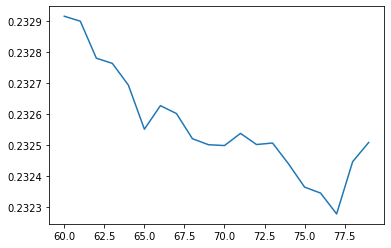

In [39]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [15]:
# It appears to have a minimum RMSE between 100 & 125
# Let's zoom in
scores = []

for n in tqdm(range(100, 126)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = mean_squared_error(y_val, y_pred, squared=False)

    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=["n_estimators", "rmse"])

  0%|          | 0/26 [00:00<?, ?it/s]

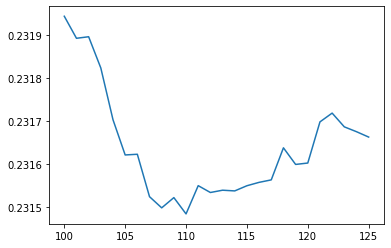

In [16]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [17]:
df_scores.sort_values("rmse", ascending=True).head(5)

,n_estimators,rmse
10,110,0.231484
8,108,0.231498
9,109,0.231522
7,107,0.231524
12,112,0.231534


After which value of n_estimators does RMSE stop improving?

* 10
* 50
* **70**
* 150

---

## Question 4

Let's select the best max_depth:

* Try different values of max_depth: [10, 15, 20, 25].
* For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
* Fix the random seed: random_state=1.

In [18]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(
        n_estimators=0,
        max_depth=d,
        random_state=1,
        n_jobs=-1,
        warm_start=True,
    )

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ["max_depth", "n_estimators", "rmse"]
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

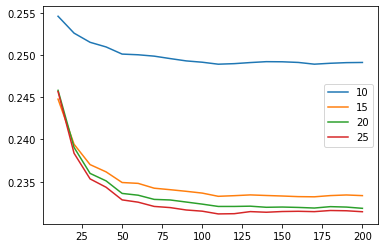

In [19]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()

What's the best max_depth:

* 10
* 15
* 20
* **25**

---

## Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:

* n_estimators=10,
* max_depth=20,
* random_state=1,
* n_jobs=-1 (optional)

Get the feature importance information from this model

In [20]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
dv.get_feature_names_out()

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'ocean_proximity=ISLAND',
       'ocean_proximity=NEAR BAY', 'ocean_proximity=NEAR OCEAN',
       'population', 'total_bedrooms', 'total_rooms'], dtype=object)

In [22]:
rf.feature_importances_

array([1.61407558e-02, 3.31967386e-02, 1.01333351e-01, 9.63405488e-02,
       3.63224176e-01, 2.76524800e-03, 3.10900842e-01, 3.56806263e-04,
       4.52770519e-04, 4.45219202e-03, 3.09988869e-02, 1.93726028e-02,
       2.04650818e-02])

In [23]:
df_importances = pd.DataFrame()
df_importances["feature"] = dv.get_feature_names_out()
df_importances["importance"] = rf.feature_importances_
df_importances.sort_values(by="importance", ascending=False).head()

,feature,importance
4,median_income,0.363224
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101333
3,longitude,0.096341
1,housing_median_age,0.033197


What's the most important feature?

* `total_rooms`
* **`median_income`**
* `total_bedrooms`
* `longitude`

---

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

* Install XGBoost.
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```

In [24]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in features
]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [25]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [26]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split("\n"):
        it_line, train_line, val_line = line.split("\t")

        it = int(it_line.strip("[]"))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(":")[1])

        results.append((it, train, val))

    columns = ["num_iter", "train_auc", "val_auc"]
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [27]:
scores = {}

In [30]:
xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(
    xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist
)

In [31]:
scores["eta=0.3"] = parse_xgb_output(output)

* Now, change eta first to 0.1 and then to 0.01.

In [32]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(
    xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist
)

In [33]:
scores["eta=0.1"] = parse_xgb_output(output)

In [34]:
xgb_params = {
    "eta": 0.01,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(
    xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist
)

In [35]:
scores["eta=0.01"] = parse_xgb_output(output)

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* **Both gives same**

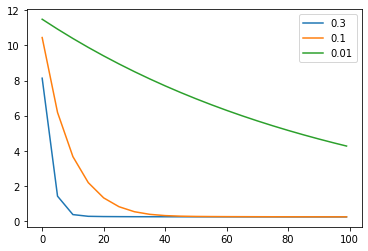

In [36]:
plt.plot(scores["eta=0.3"].num_iter, scores["eta=0.3"].val_auc, label="0.3")
plt.plot(scores["eta=0.1"].num_iter, scores["eta=0.1"].val_auc, label="0.1")
plt.plot(scores["eta=0.01"].num_iter, scores["eta=0.01"].val_auc, label="0.01")
plt.legend()

# plt.ylim([0.43, 0.45])
# plt.xlim([50, 100])

(30.0, 100.0)

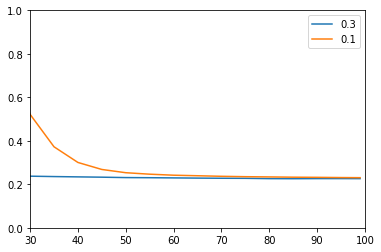

In [37]:
plt.plot(scores["eta=0.3"].num_iter, scores["eta=0.3"].val_auc, label="0.3")
plt.plot(scores["eta=0.1"].num_iter, scores["eta=0.1"].val_auc, label="0.1")
plt.legend()

plt.ylim([0, 1])
plt.xlim([30, 100])

---

## Submit the results

* Submit your results here: https://forms.gle/3yMSuQ4BeNuZFHTU8
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one


## Deadline

The deadline for submitting is 17 October (Monday), 23:00 CEST.

After that, the form will be closed.

--- 

# Learning in Public

* https://twitter.com/David__Colton/status/1578369366315634689?s=20&t=4XWgVuR_aWD5Zt8C0MmafA
* https://twitter.com/David__Colton/status/1578421142422814724?s=20&t=70u9E4vRriRgGteBjDYt9A
* https://twitter.com/David__Colton/status/1578525637001629698?s=20&t=oyal55UlnE3exwNeJOkv8g
* https://twitter.com/David__Colton/status/1578738430749483009?s=20&t=iu5Nm1A6DlrC0137K57pZg
* https://twitter.com/David__Colton/status/1579044528023302146?s=20&t=vZ7wLrPvesbjgRVdn6ZA9A
* https://twitter.com/David__Colton/status/1579096764552208385?s=20&t=fzHQkNJlE4Y1BnevW_4yxg
* https://twitter.com/David__Colton/status/1579153031543001088?s=20&t=u8CF8HJVSrbyvL2vw9AhWA
* https://twitter.com/David__Colton/status/1579572274570874880?s=20&t=EDPz4IGOuzmnh3mGPGAG7w
* https://twitter.com/David__Colton/status/1579575663677538304?s=20&t=iMcb5Vq-FyK-20DJWeG0Yw
* https://twitter.com/David__Colton/status/1579576846186074113?s=20&t=AGIYylE9vhG0nVucgXOQbg